In [1]:
import os
import os.path
import sys 

from pathlib import Path
from random import choice

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2.5.0


In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# data set

* [camvid dataset](https://www.kaggle.com/carlolepelaars/camvid)

* https://www.kaggle.com/carlolepelaars/camvid

# make data loader 

In [4]:
datapath = "D:\\programing\\DataSets\\segmentain\\CamVid"
print(os.listdir(datapath))

['class_dict.csv', 'test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']


In [5]:
dataset_path = Path(datapath)
list(dataset_path.iterdir())

[WindowsPath('D:/programing/DataSets/segmentain/CamVid/class_dict.csv'),
 WindowsPath('D:/programing/DataSets/segmentain/CamVid/test'),
 WindowsPath('D:/programing/DataSets/segmentain/CamVid/test_labels'),
 WindowsPath('D:/programing/DataSets/segmentain/CamVid/train'),
 WindowsPath('D:/programing/DataSets/segmentain/CamVid/train_labels'),
 WindowsPath('D:/programing/DataSets/segmentain/CamVid/val'),
 WindowsPath('D:/programing/DataSets/segmentain/CamVid/val_labels')]

In [6]:
train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))

print("train: ", (len(train_imgs), len(train_labels)) )
print("test: ", (len(val_imgs), len(val_labels)) ) 
print("test: ", (len(test_imgs), len(test_labels)) )


train:  (369, 369)
test:  (100, 100)
test:  (232, 232)


In [7]:
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        if (dataset / label / (im.stem +"_L.png" )).exists():
            pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [8]:
train_pairs = make_pair(train_imgs, "train_labels", dataset_path)
val_pairs = make_pair(val_imgs, "val_labels", dataset_path)
test_pairs = make_pair(test_imgs, "test_labels", dataset_path)

In [9]:
img_size = 256

## plot some image

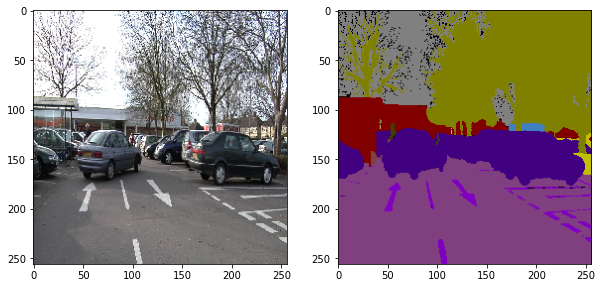

In [10]:
temp = choice(train_pairs)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [11]:
class_map_df = pd.read_csv(dataset_path / "class_dict.csv")

class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))

num_classes = len(class_map)
num_classes

32

# build data loader 

In [12]:
from SegmentationDataLoader import DataGenerator

adding test data to train data, since data set in a bit small 

In [13]:
train_generator = DataGenerator(train_pairs+test_pairs, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

150

In [14]:
val_generator = DataGenerator(val_pairs, class_map, batch_size=8, dim=(img_size,img_size,3) ,shuffle=False)
val_steps = val_generator.__len__()
val_steps

12

# import LinkNet model 

In [15]:
from LinkNetModel import GetLinkNetModel

In [16]:
input_shape=(img_size,img_size,3)
model = GetLinkNetModel(input_shape,init_filters=64,n_levels=4, out_channels=len(class_map))

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

## add callbacks 
tring out the ReduceLROnPlateau

In [18]:
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=8, verbose=0, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_accuracy',factor=0.1, patience=4, verbose=1, mode="max", min_lr=0.00001)

callbacks=[es,rl]

# trainning the model 

In [19]:
history = model.fit(train_generator , steps_per_epoch=train_steps ,epochs=35,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=callbacks)

Epoch 1/35
150/150 [==============================] - 48s 290ms/step - loss: 1.7939 - accuracy: 0.5540 - val_loss: 1.9361 - val_accuracy: 0.4913
Epoch 2/35
150/150 [==============================] - 43s 284ms/step - loss: 1.1502 - accuracy: 0.6593 - val_loss: 1.1272 - val_accuracy: 0.6675
Epoch 3/35
150/150 [==============================] - 43s 284ms/step - loss: 1.0238 - accuracy: 0.7053 - val_loss: 1.3970 - val_accuracy: 0.5889
Epoch 4/35
150/150 [==============================] - 43s 284ms/step - loss: 0.9206 - accuracy: 0.7557 - val_loss: 1.5709 - val_accuracy: 0.5800
Epoch 5/35
150/150 [==============================] - 43s 285ms/step - loss: 0.8466 - accuracy: 0.7774 - val_loss: 0.8463 - val_accuracy: 0.7704
Epoch 6/35
150/150 [==============================] - 43s 284ms/step - loss: 0.7788 - accuracy: 0.7926 - val_loss: 0.7876 - val_accuracy: 0.7829
Epoch 7/35
150/150 [==============================] - 43s 284ms/step - loss: 0.7270 - accuracy: 0.8057 - val_loss: 0.6833 - val_ac

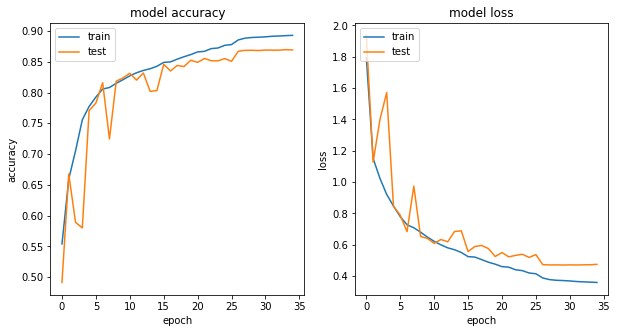

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# evaluate the model 
## helper function 

In [21]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [22]:
def image_form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [23]:
def plot_seg_result(img, gt_img, pred_colored):
    plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(img/255.)
    plt.subplot(132)
    plt.title('True labels')
    plt.imshow(gt_img/255.)
    plt.subplot(133)
    plt.imshow(pred_colored/255.)
    plt.title('predicted labels')

# plot results 

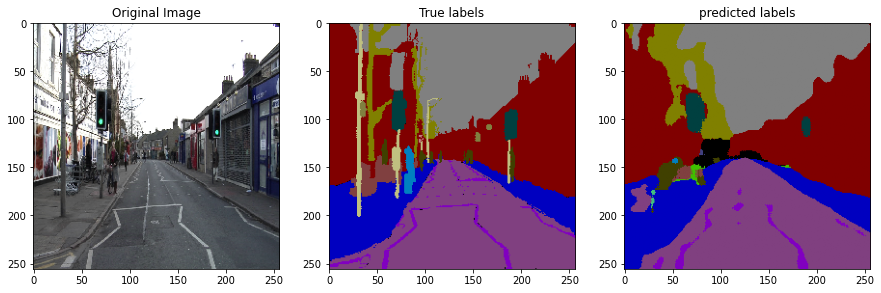

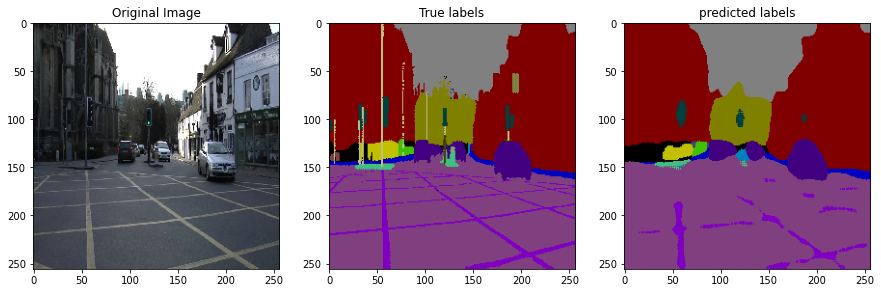

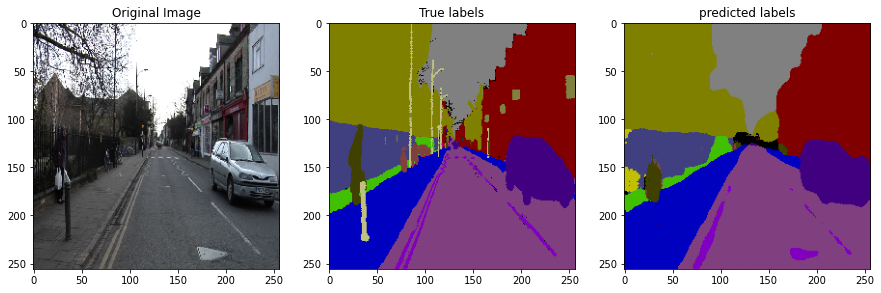

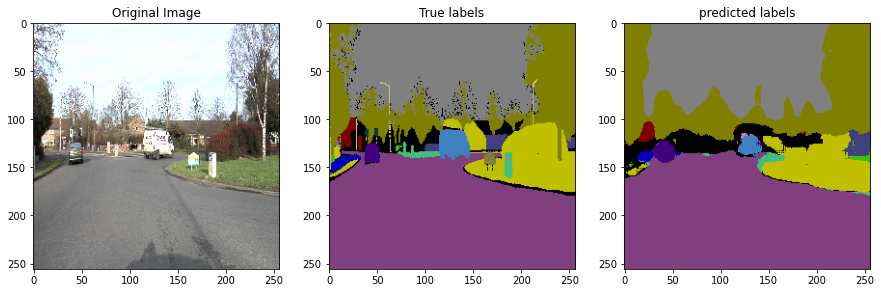

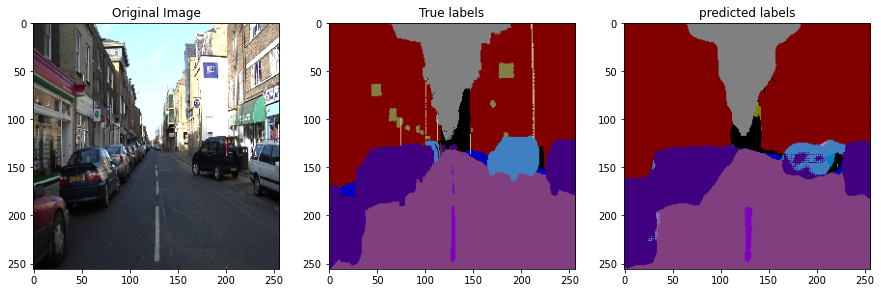

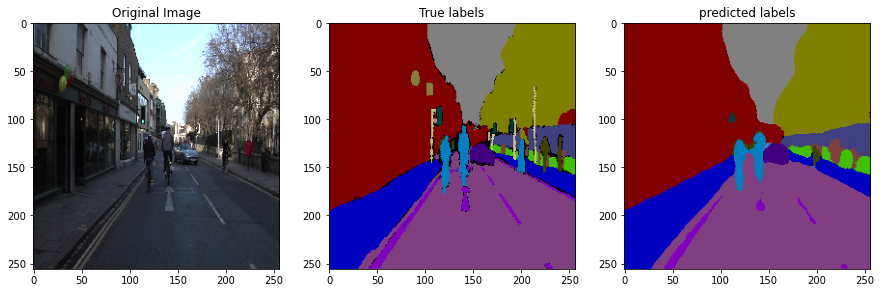

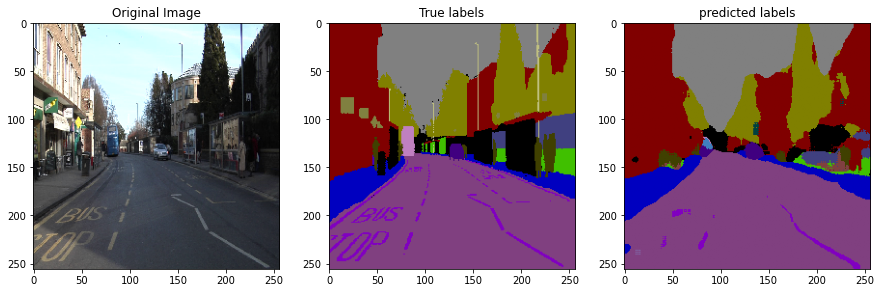

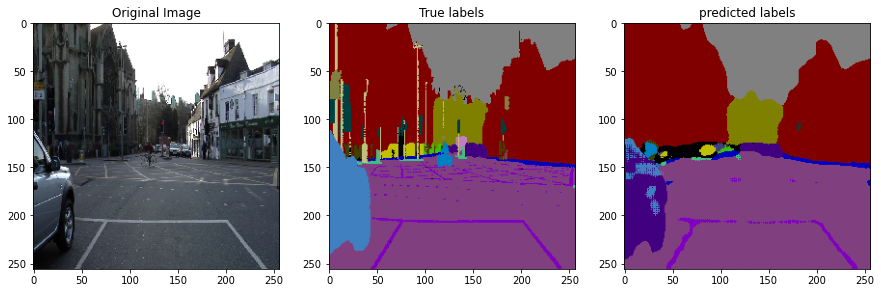

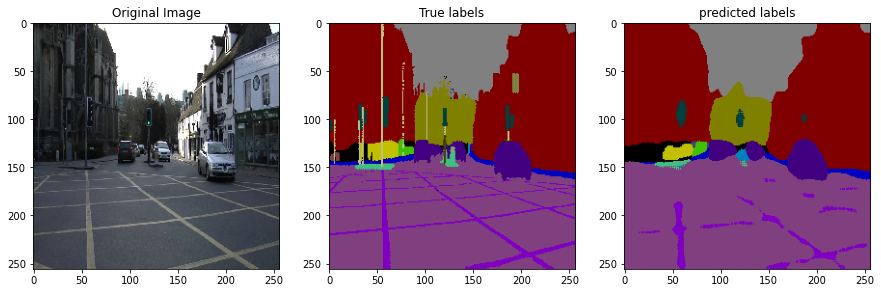

In [24]:
for _ in range(9):
    img_mask = choice(val_pairs)
    img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
    gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))
    pred_label = make_prediction(model, img_mask[0], (img_size,img_size,3))
    pred_colored = image_form_colormap(pred_label,np.array(class_map))
    plot_seg_result(img, gt_img, pred_colored)
